In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [ ]:
df = pd.read_csv('HIV_dataset.csv')

print(df.head())

print(df.describe())

   Age  MARSTA  STDPYR  EDUCBG  HIVTST  AIDSED  SEEKSP  SEXORI  DRUGTK  \
0   47       1       0       5       1       0       1       1       1   
1   38       1       0       5       0       1       0       1       0   
2   49       2       1       5       0       1       0       3       0   
3   35       2       0       5       1       1       3       1       1   
4   35       1       1       3       1       0       2       1       1   

   HIVRES  EMPYST  
0       2       1  
1       1       6  
2       1       3  
3       2       2  
4       2       1  
              Age      MARSTA      STDPYR      EDUCBG      HIVTST      AIDSED  \
count  698.000000  698.000000  698.000000  698.000000  698.000000  698.000000   
mean    46.103152    2.206304    0.468481    3.684814    0.386819    0.408309   
std     11.278436    1.328580    0.499363    1.683177    0.487371    0.491873   
min     30.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%     35.000000    1.000000 

##Rename/Remap

In [ ]:
# Rename column to be more descriptive
df = df.rename(columns={
    'AGE': 'Age',
    'MARSTA': 'MaritalStatus',
    'STDPYR': 'RecentSTD',
    'EDUCBG': 'Education',
    'HIVTST': 'TestedPastYear',
    'AIDSED': 'AIDSEducation',
    'SEEKSP': 'PartnerLocation',
    'SEXORI': 'SexualOrientation',
    'DRUGTK': 'DrugUse',
    'HIVRES': 'HIV_Result',
    'EMPYST': 'EmploymentStatus'
})

# Recode the numerical response to categorical
recode_maps = {
    'MaritalStatus': {
        1: 'Unmarried', 2: 'Married', 3: 'Divorced', 4: 'Cohabiting', 5: 'Widowed'
    },
    'RecentSTD': {
        1: 'Yes', 0: 'No'
    },
    'Education': {
        1: 'Primary School', 2: 'Middle School', 3: 'High School',
        4: 'Some College', 5: 'College', 6: 'Illiteracy'
    },
    'TestedPastYear': {
        1: 'Yes', 0: 'No'
    },
    'AIDSEducation': {
        1: 'Yes', 0: 'No'
    },
    'PartnerLocation': {
        0: 'None', 1: 'Bar', 2: 'Internet/Dating Apps', 3: 'Work/School',
        4: 'Public Place', 5: 'Other'
    },
    'SexualOrientation': {
        1: 'Heterosexual', 2: 'Homosexual', 3: 'Bisexual', 4: 'Other'
    },
    'DrugUse': {
        1: 'Yes', 0: 'No'
    },
    'HIV_Result': {
        1: 'Negative', 2: 'Positive'
    },
     'EmploymentStatus': {
        1: 'Full-Time', 2: 'Part-Time', 3: 'Unemployed', 4: 'Student', 5: 'Retired', 6: 'Disabled'
    }
}

for col, mapping in recode_maps.items():
    df[col] = df[col].map(mapping)

# Create a binary column for modeling (1 = Positive, 0 = Negative)
df['HIV_Result_Binary'] = df['HIV_Result'].map({'Negative': 0, 'Positive': 1})

# Create age buckets
df['AgeGroup'] = pd.cut(
    df['Age'],
    bins=[30, 40, 50, 60, 70],
    labels=['30-39', '40-49', '50-59', '60-70'],
    right=True
)

#Preview data
print(df.head())

   Age MaritalStatus RecentSTD    Education TestedPastYear AIDSEducation  \
0   47     Unmarried        No      College            Yes            No   
1   38     Unmarried        No      College             No           Yes   
2   49       Married       Yes      College             No           Yes   
3   35       Married        No      College            Yes           Yes   
4   35     Unmarried       Yes  High School            Yes            No   

        PartnerLocation SexualOrientation DrugUse HIV_Result EmploymentStatus  \
0                   Bar      Heterosexual     Yes   Positive        Full-Time   
1                  None      Heterosexual      No   Negative         Disabled   
2                  None          Bisexual      No   Negative       Unemployed   
3           Work/School      Heterosexual     Yes   Positive        Part-Time   
4  Internet/Dating Apps      Heterosexual     Yes   Positive        Full-Time   

   HIV_Result_Binary AgeGroup  
0                  1    

#Risk Analyses

In [ ]:
categorical_vars = [
    'MaritalStatus',
    'RecentSTD',
    'Education',
    'TestedPastYear',
    'AIDSEducation',
    'PartnerLocation',
    'SexualOrientation',
    'DrugUse',
    'AgeGroup',  # includes 30-70 properly
    'EmploymentStatus'
]

risk_analysis_results = []

# Loop through each variable and perform chi-square + risk proportion
for col in categorical_vars:
    # Create a contingency table
    contingency = pd.crosstab(df[col], df['HIV_Result_Binary'])

    # Only proceed if we have HIV+ cases in the column
    if 1 in contingency.columns:
        # Chi-square test
        chi2, p, dof, ex = chi2_contingency(contingency)

        # Calculate HIV+ proportions row-wise
        proportions = contingency.div(contingency.sum(1), axis=0)
        top_group = proportions[1].idxmax()  # group with highest HIV+ rate
        top_risk = proportions[1].max()

        # Store results
        risk_analysis_results.append({
            'Variable': col,
            'Highest Risk Group': top_group,
            'HIV+ Proportion': round(top_risk, 2),
            'p-value': round(p, 4)
        })

# Convert to DataFrame
risk_df = pd.DataFrame(risk_analysis_results)

# Display  DataFrame
print(risk_df)

            Variable    Highest Risk Group  HIV+ Proportion  p-value
0      MaritalStatus             Unmarried             0.54   0.2289
1          RecentSTD                   Yes             0.56   0.0032
2          Education           High School             0.53   0.6763
3     TestedPastYear                    No             0.55   0.0009
4      AIDSEducation                    No             0.58   0.0000
5    PartnerLocation  Internet/Dating Apps             0.81   0.0000
6  SexualOrientation            Homosexual             0.56   0.1584
7            DrugUse                    No             0.59   0.0000
8           AgeGroup                 40-49             0.52   0.5291
9   EmploymentStatus            Unemployed             0.55   0.4742


In [ ]:
risk_df = pd.DataFrame(risk_analysis_results)


##Graphs

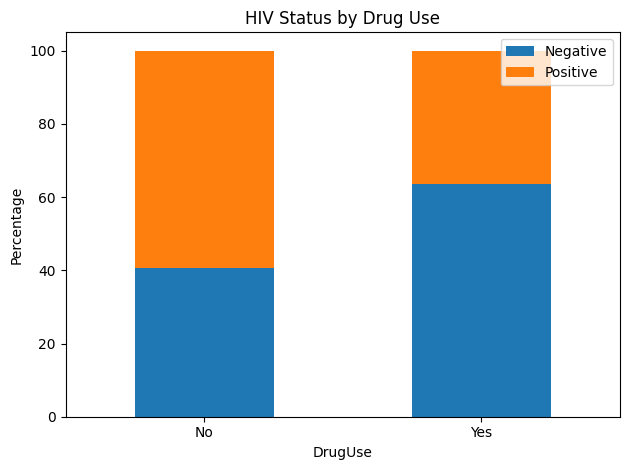

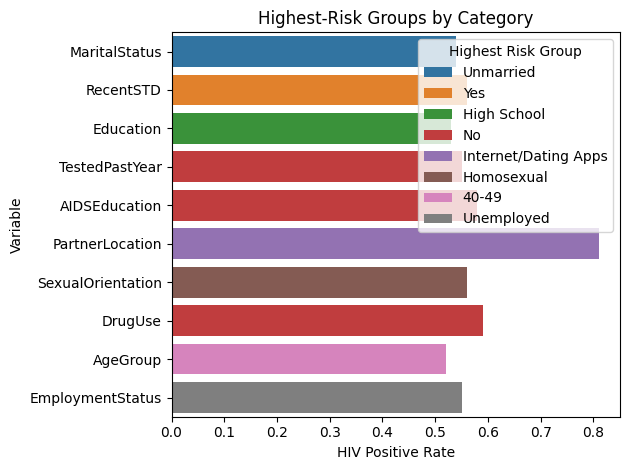

<ipython-input-8-e15303b91148>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


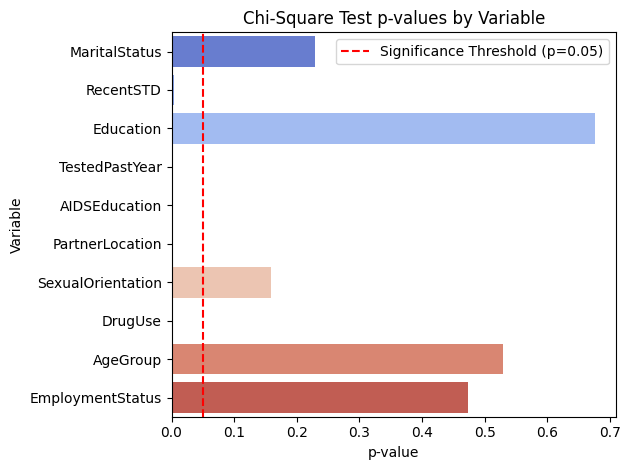

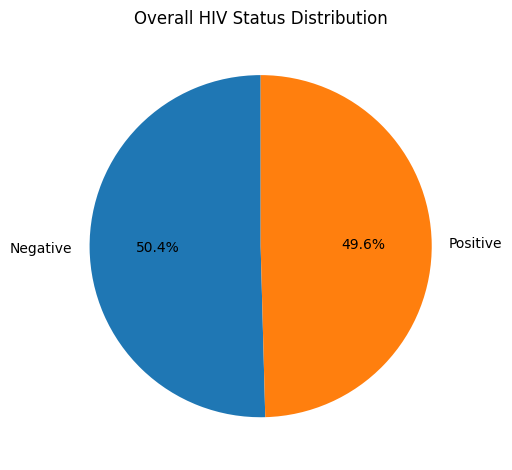

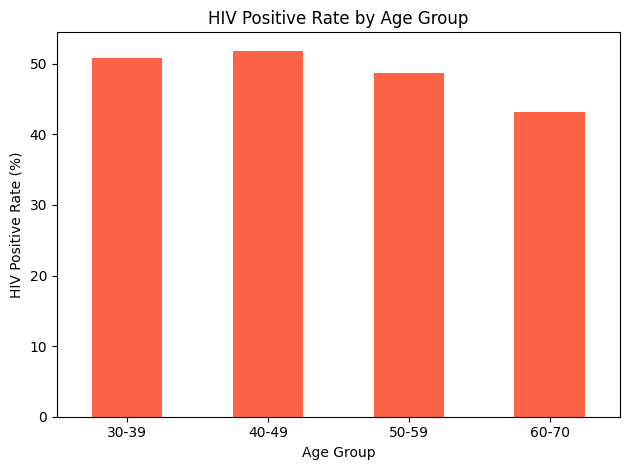

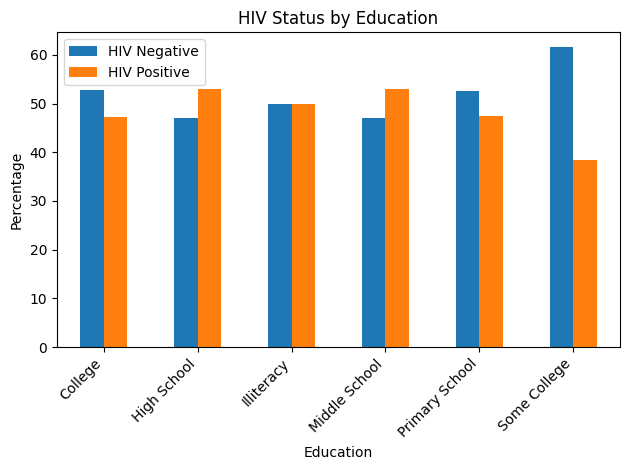

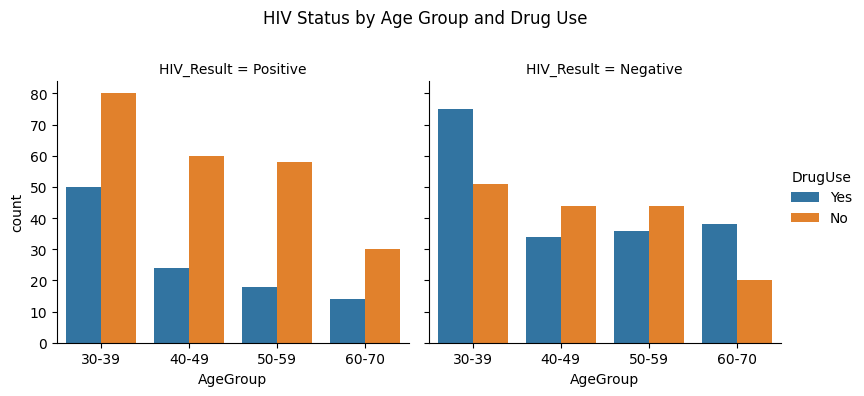

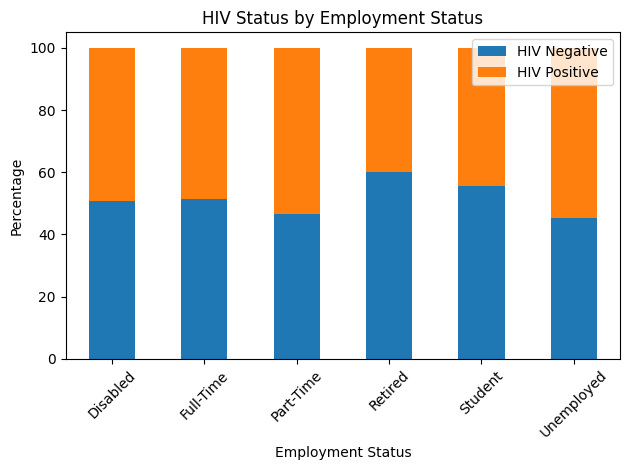

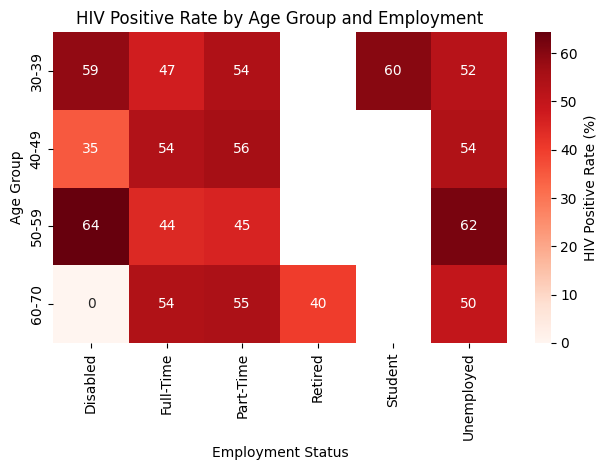

In [ ]:
# 1. Stacked Bar Chart for Drug Use
plot_data = pd.crosstab(df['DrugUse'], df['HIV_Result'], normalize='index') * 100
plot_data.rename(columns={0: 'HIV Negative', 1: 'HIV Positive'}, inplace=True)
plot_data.plot(kind='bar', stacked=True)
plt.title("HIV Status by Drug Use")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 2. Horizontal Barplot of Highest-Risk Groups
sns.barplot(
    y=risk_df['Variable'],
    x=risk_df['HIV+ Proportion'],
    hue=risk_df['Highest Risk Group'],
    dodge=False
)
plt.xlabel("HIV Positive Rate")
plt.title("Highest-Risk Groups by Category")
plt.tight_layout()
plt.show()

# 3. Heatmaps of HIV+ Rate by Each Categorical Variable
for var in [
    'MaritalStatus', 'RecentSTD', 'Education', 'TestedPastYear',
    'AIDSEducation', 'PartnerLocation', 'SexualOrientation', 'DrugUse'
]:
    cross = pd.crosstab(df[var], df['HIV_Result'], normalize='index') * 100
    if 1 in cross.columns:
        sns.heatmap(cross[[1]], annot=True, cmap="Reds", cbar_kws={'label': 'HIV Positive %'})
        plt.title(f"HIV Positive Rate by {var.replace('_', ' ')}")
        plt.ylabel(var.replace("_", " "))
        plt.xlabel("HIV Status")
        plt.tight_layout()
        plt.show()

# 4. Barplot of Chi-Square p-values for Each Variable
sns.barplot(
    x=risk_df['p-value'],
    y=risk_df['Variable'],
    palette="coolwarm"
)
plt.axvline(0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.xlabel("p-value")
plt.title("Chi-Square Test p-values by Variable")
plt.legend()
plt.tight_layout()
plt.show()

# 5. Pie Chart of Overall HIV Status
df['HIV_Result'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%',
    labels=['Negative', 'Positive'],
    startangle=90
)
plt.title("Overall HIV Status Distribution")
plt.ylabel("")
plt.tight_layout()
plt.show()

# 6. Bar Chart: HIV+ Rate by Age Group
age_plot = pd.crosstab(df['AgeGroup'], df['HIV_Result_Binary'], normalize='index') * 100
age_plot = age_plot.rename(columns={0: 'HIV Negative (%)', 1: 'HIV Positive (%)'})

age_plot['HIV Positive (%)'].plot(kind='bar', color='tomato')
plt.title("HIV Positive Rate by Age Group")
plt.ylabel("HIV Positive Rate (%)")
plt.xlabel("Age Group")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 7. Grouped Bar Chart: HIV Status by Education
edu_plot = pd.crosstab(df['Education'], df['HIV_Result_Binary'], normalize='index') * 100
edu_plot.plot(kind='bar')
plt.title("HIV Status by Education")
plt.ylabel("Percentage")
plt.xticks(rotation=45, ha='right')
plt.legend(['HIV Negative', 'HIV Positive'])
plt.tight_layout()
plt.show()

# 8. Multi-Variable Comparison
sns.catplot(
    x="AgeGroup",
    hue="DrugUse",
    col="HIV_Result",
    data=df,
    kind="count",
    height=4,
    aspect=1
)
plt.subplots_adjust(top=0.8)
plt.suptitle("HIV Status by Age Group and Drug Use")
plt.show()

# 9. Stacked Bar Chart: HIV Status by Employment
plot_data = pd.crosstab(df['EmploymentStatus'], df['HIV_Result_Binary'], normalize='index') * 100
plot_data.rename(columns={0: 'HIV Negative', 1: 'HIV Positive'}, inplace=True)
plot_data.plot(kind='bar', stacked=True)
plt.title("HIV Status by Employment Status")
plt.ylabel("Percentage")
plt.xlabel("Employment Status")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 10. Heatmap: HIV Positive Rate by Employment and Age Group
heat_data = pd.crosstab(
    df['AgeGroup'], df['EmploymentStatus'], values=df['HIV_Result_Binary'],
    aggfunc='mean'
)
sns.heatmap(heat_data * 100, annot=True, cmap="Reds", cbar_kws={'label': 'HIV Positive Rate (%)'})
plt.title("HIV Positive Rate by Age Group and Employment")
plt.xlabel("Employment Status")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()